# Deep GV
-------
This notebook contains two parts. The first part is a simple demo of deep graph library we use. The second part is our deep graph value network.

# Graph Classification Demo

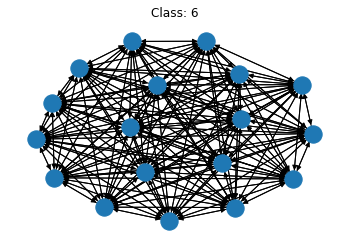

In [32]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[60]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [67]:
import dgl
import torch

# Batch data together
def collate(samples):
    # the input samples are list of (graph, label) pairs
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [55]:
from dgl.nn.pytorch import GraphConv

In [91]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float().cuda()
#         print(h.is_cuda)
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # aggregate graph features
        hg = dgl.mean_nodes(g, 'h')
        
        return self.classify(hg)
        

In [ ]:
# import torch.optim as optim
from torch.utils.data import DataLoader


# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        bg, label = bg.to(device), label.to(device)
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

# Graph Attention Value Iteration Network

## solve MDP with VI

In [1]:
import numpy as np # used for random
from functools import lru_cache # Used to cache results.
import copy


class MDP:
    def __init__(self, states, actions, transition_function, reward_function, gamma=.6):
        self.states = states # a list
        self.actions = actions # a list
        self.transition_function = transition_function # s, a -> distribution: {s:p, s:p, ...}
        self.reward_function = reward_function # s, a -> R
        self.gamma = 0.6

def make_goal_based_reward(goal_state):
    def func_to_return(state, action):
        if (state==goal_state):
            return 1.0
        else:
            
            return 0
    return func_to_return

def make_nd_grid_s_a(dim_vector, random_obstacle_density = 0.0, goal_state = None):
    if (goal_state is None):
        goal_state = (length - 1 for length in dim_vector)

    actions = []
    for index in range(len(dim_vector)):
        actions.append('+' + str(index))
        actions.append('-' + str(index))
    
    states = [()]
    for size in dim_vector:
        new_states = []
        for index in range(size):
                new_states.extend([state + (index,) for state in states])
        states = new_states

    # randomly remove states
    states = [state for state in states if (np.random.uniform() > random_obstacle_density) or (state==goal_state)]

    # add a trap state / sink state
    states.append( tuple(dimension for dimension in dim_vector) )

    return states, actions

def make_nd_froom_s_a(dim_vector, random_obstacle_density = 0.0, goal_state = None):
    # make a four room world. only tested in 2d
    # TODO:should support higher dimensions
    unique_dim = np.unique(dim_vector)
    if len(unique_dim) !=  1:
        raise ValueError("Every entry of dimension vectors should be same. Four room is a square-like grids.")
    for dim, size in enumerate(dim_vector):
        if size % 2 == 0:
            raise ValueError("Dim" + str(dim) + " size should be an odd, instead of " + str(size))

    if (goal_state is None):
        goal_state = (length - 1 for length in dim_vector)

    actions = []
    for index in range(len(dim_vector)):
        actions.append('+' + str(index))
        actions.append('-' + str(index))

    states = [()]
    for size in dim_vector:
        new_states = []
        for index in range(size):
            new_states.extend([state + (index,) for state in states])
        states = new_states

    # randomly remove states
    states = [state for state in states if (np.random.uniform() > random_obstacle_density) or (state==goal_state)]

    # remove some states to be middle walls
    wall_states = []
    for dim, size in enumerate(dim_vector):
        wall_coordinate = (size - 1) / 2 
        wall_state = [(i,) for i in range(size) if i != wall_coordinate - 2 and i != wall_coordinate + 2]
        wall_state = [tuple(np.insert(state, dim, wall_coordinate).tolist()) for state in wall_state]
        wall_states.extend(wall_state)
    
    print("wall_states:\n"+str(wall_states))
    states = list(set(states) - set(wall_states))
    # print(sorted(states))

    # add a trap state / sink state
    states.append( tuple(dimension for dimension in dim_vector) )

    return states, actions

def make_bounded_grid_transition(states, actions, terminal_states, sink_state, stochasticity=0.0):
    # Actions are + or - and a corresponding dimension index.
    # Transitions are slightly stochastic. On failure, it takes a random action.
    # Some states are un-enterable. They are obstacles.
    # In other words, new obstacles can be created just by removing states from the statespace.
    
    # Build a set of states
    states = frozenset(states)
    terminal_states = frozenset(terminal_states)

    @lru_cache(maxsize=None) # Caches all transitions when they are looked up.
    def func_to_return(state, action_to_take):
        if state in terminal_states:
            return {sink_state: 1.0}
        
        # (implicit) else:

        # Determine the set of possible future states (across all actions)
        state_to_probability = {state: 0.0}

        for action in actions:
            next_state = copy.copy(list(state))
            dimension = int(action[1:])
            if action[0]=="+":
                next_state[dimension] += 1
            else:
                next_state[dimension] -= 1
            
            probability = stochasticity/(len(actions)-1)

            if (action == action_to_take):
                probability = 1 - stochasticity
            
            next_state = tuple(next_state)
            if (next_state not in states) or probability <= 0.0:
                state_to_probability[state] += probability
            else:
                state_to_probability[next_state] = probability

        return state_to_probability
    
    return func_to_return


def make_nd_grid_world(dimension_vector, stochasticity=0.0):
    goal_state = tuple(length - 1 for length in dimension_vector)
    # sink_state = tuple(-1 for length in dimension_vector)
    sink_state = tuple(length for length in dimension_vector)
    reward_function = make_goal_based_reward(goal_state)
    states, actions = make_nd_grid_s_a(dimension_vector)
    transition_function = make_bounded_grid_transition(states, actions, [goal_state], sink_state, stochasticity=stochasticity)
    mdp = MDP(states, actions, transition_function, reward_function)

    return mdp

def make_nd_four_room(dimension_vector, stochasticity=0.0):
    goal_state = tuple(length - 1 for length in dimension_vector)
    # sink_state = tuple(-1 for length in dimension_vector)
    sink_state = tuple(length for length in dimension_vector)
    reward_function = make_goal_based_reward(goal_state)
    states, actions = make_nd_froom_s_a(dimension_vector)
    transition_function = make_bounded_grid_transition(states, actions, [goal_state], sink_state, stochasticity=stochasticity)
    mdp = MDP(states, actions, transition_function, reward_function)

    return mdp
    

# TODO: nd_grid_world variants (4 rooms, mazes, random block obstacles)

In [2]:
import math
import copy
import random

class ValueIteration:
    def __init__(self, mdp):
        self.mdp = mdp
        self.values = {} # Filled in later, used to compute value errors
        self.action_values = {} # (states, action): value
        self.bellman_backups = 0
        self.value_lookups = 0
        self.value_sequence = []
        self.backup_counts = []
        self.lookup_counts = []
        self.partition_values = {}

    def solve(self, epsilon=None):
        if (epsilon is None):
            epsilon = math.pow(self.mdp.gamma, len(self.mdp.states)) # TODO: Make more precise if needed.
        values = {state: 0.0 for state in self.mdp.states}
        max_diff = 2 * epsilon
        counter = 0
        total_iter = 0
        value_rank = [i[0] for i in sorted(values.items(), key=lambda x:x[1])]
        while max_diff > epsilon:
            self.value_sequence.append(values)
            self.backup_counts.append(self.bellman_backups)
            self.lookup_counts.append(self.value_lookups)
            max_diff = 0.0
            new_values = copy.copy(values)
            # Iterate over states
            for state in self.mdp.states:
                action_values = []
                for action in self.mdp.actions:
                    reward = self.mdp.reward_function(state, action)
                    transitions = self.mdp.transition_function(state, action)
                    self.value_lookups += len(transitions) # How many value lookups are made. Used for counting purposes.
                    expected_values = sum([values[new_state]*transitions[new_state] for new_state in transitions]) # TODO: a bug here? should be updated using values instead of new_values
                    value = reward + self.mdp.gamma * expected_values
                    action_values.append(value)
                    self.action_values[(state, action)] = value
                new_values[state] = max(action_values)
                self.bellman_backups += 1 # used for counting purposes.
                max_diff = max(abs(new_values[state] - values[state]), max_diff) # update for termination condition
            values = new_values
            new_value_rank = [i[0] for i in sorted(new_values.items(), key=lambda x:x[1])]
            total_iter += 1
#             print(value_rank)
            if np.allclose(new_value_rank, value_rank):
                counter += 1
            if counter > 1:
                print('total iter: %d'%total_iter )
#                 print(value_rank)
                break
            value_rank = new_value_rank
            self.value_sequence.append(values) # One last time.
            self.backup_counts.append(self.bellman_backups)
            self.lookup_counts.append(self.value_lookups)
        
        print('iter: %d | counter: %d'%(total_iter, counter))
        self.values = values
        return values # Return values when finished.

    def compute_values_vs_backups(self):
        differences = []
        for intermediate_values in self.value_sequence:
            max_err = max([abs(intermediate_values[state] - self.values[state]) for state in self.values])
            differences.append(max_err)

        return self.lookup_counts, differences #self.backup_counts, differences


In [3]:
import networkx as nx
import types
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict

TEST = 0

def grid2graph(mdp: MDP) -> (nx.Graph(), list):
    """
    Map a given MDP to a directed graph
    """
    G = nx.DiGraph()
    labels = {}
    states_sorted = sorted(mdp.states)
    for i, state in enumerate(states_sorted):
        # next_states = defaultdict(float)  #this is for sum prob
        next_states = defaultdict(list)    # this is for max/min prob

        labels[i] = state
        for action in mdp.actions:
            transition = mdp.transition_function(state, action)
            for n_state in transition:
                next_states[n_state].append(transition[n_state])
        
        # add weighted edges to the graph
        G.add_edges_from([(i, states_sorted.index(s), {'weight': max(next_states[s])}) for s in next_states])
    if TEST:
        for e in G.edges:
            print(G.edges[e])
    return (G, labels)
  
def edge_aggregation(graph: nx.Graph(), key: types.LambdaType, attribute_name: str) -> nx.Graph():
    """
    Aggragate multiple edges between two nodes into one with a given funciton
    @key: a lambda function that takes into two/multiple edges between two nodes and aggregate them into one edge
    """
    #undirected graph
    edges_visited = []
    un_G = nx.Graph()
    for node in graph:
        for nei in graph.neighbors(node):
            # discard self loop
            if (node, nei) in edges_visited or node == nei:
                continue
            elif graph.has_edge(nei, node) == False:
                weight1 = graph.get_edge_data(node, nei)[attribute_name]
                weight2 = 0
                # if we assume that when only single link exists, the other link weight/transition prob is zero
                # then it should be...
                # un_G.add_edge(node, nei, weight=round(key(weight1, weight2)))
                # or we can now just simply set sink state weight to be zero
                if nei == sorted(graph)[-1]:
                    un_G.add_edge(node, nei, weight=round(key(weight1, weight2)))
                else:
                    un_G.add_edge(node, nei, weight=round(graph.get_edge_data(node, nei)[attribute_name]))
                edges_visited.append((node, nei))
            else:
                weight1 = graph.get_edge_data(node, nei)[attribute_name]
                weight2 = graph.get_edge_data(nei, node)[attribute_name]
                un_G.add_edge(node, nei, weight=round(key(weight1, weight2)))
                edges_visited.append((node, nei))
                edges_visited.append((nei, node))

    return un_G


def draw_graph(graph, graph_name, labels, parts, colors, attr_name='weight', label_dict=None):
    plt.clf()
    # graph_name = 'un_mdp'
    # pos=nx.spring_layout(graph, pos=label_dict)
    # print(pos)
    # pos=nx.random_layout(graph)
    # pos = None
    pos = label_dict
    plt.figure(figsize=[8, 6], dpi=800)
    
    for i, part in enumerate(parts):
        nx.draw_networkx_nodes(graph, pos, nodelist = [i], node_color=colors[part])
        
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=4)
#     nx.draw_networkx_edge_labels(graph, pos, font_size=3, edge_labels={edge:graph.get_edge_data(edge[0], edge[1], default=-999)[attr_name] for edge in graph.edges()})
#     plt.savefig(graph_name+'.png', dpi=500)
    plt.show()

<Figure size 432x288 with 0 Axes>

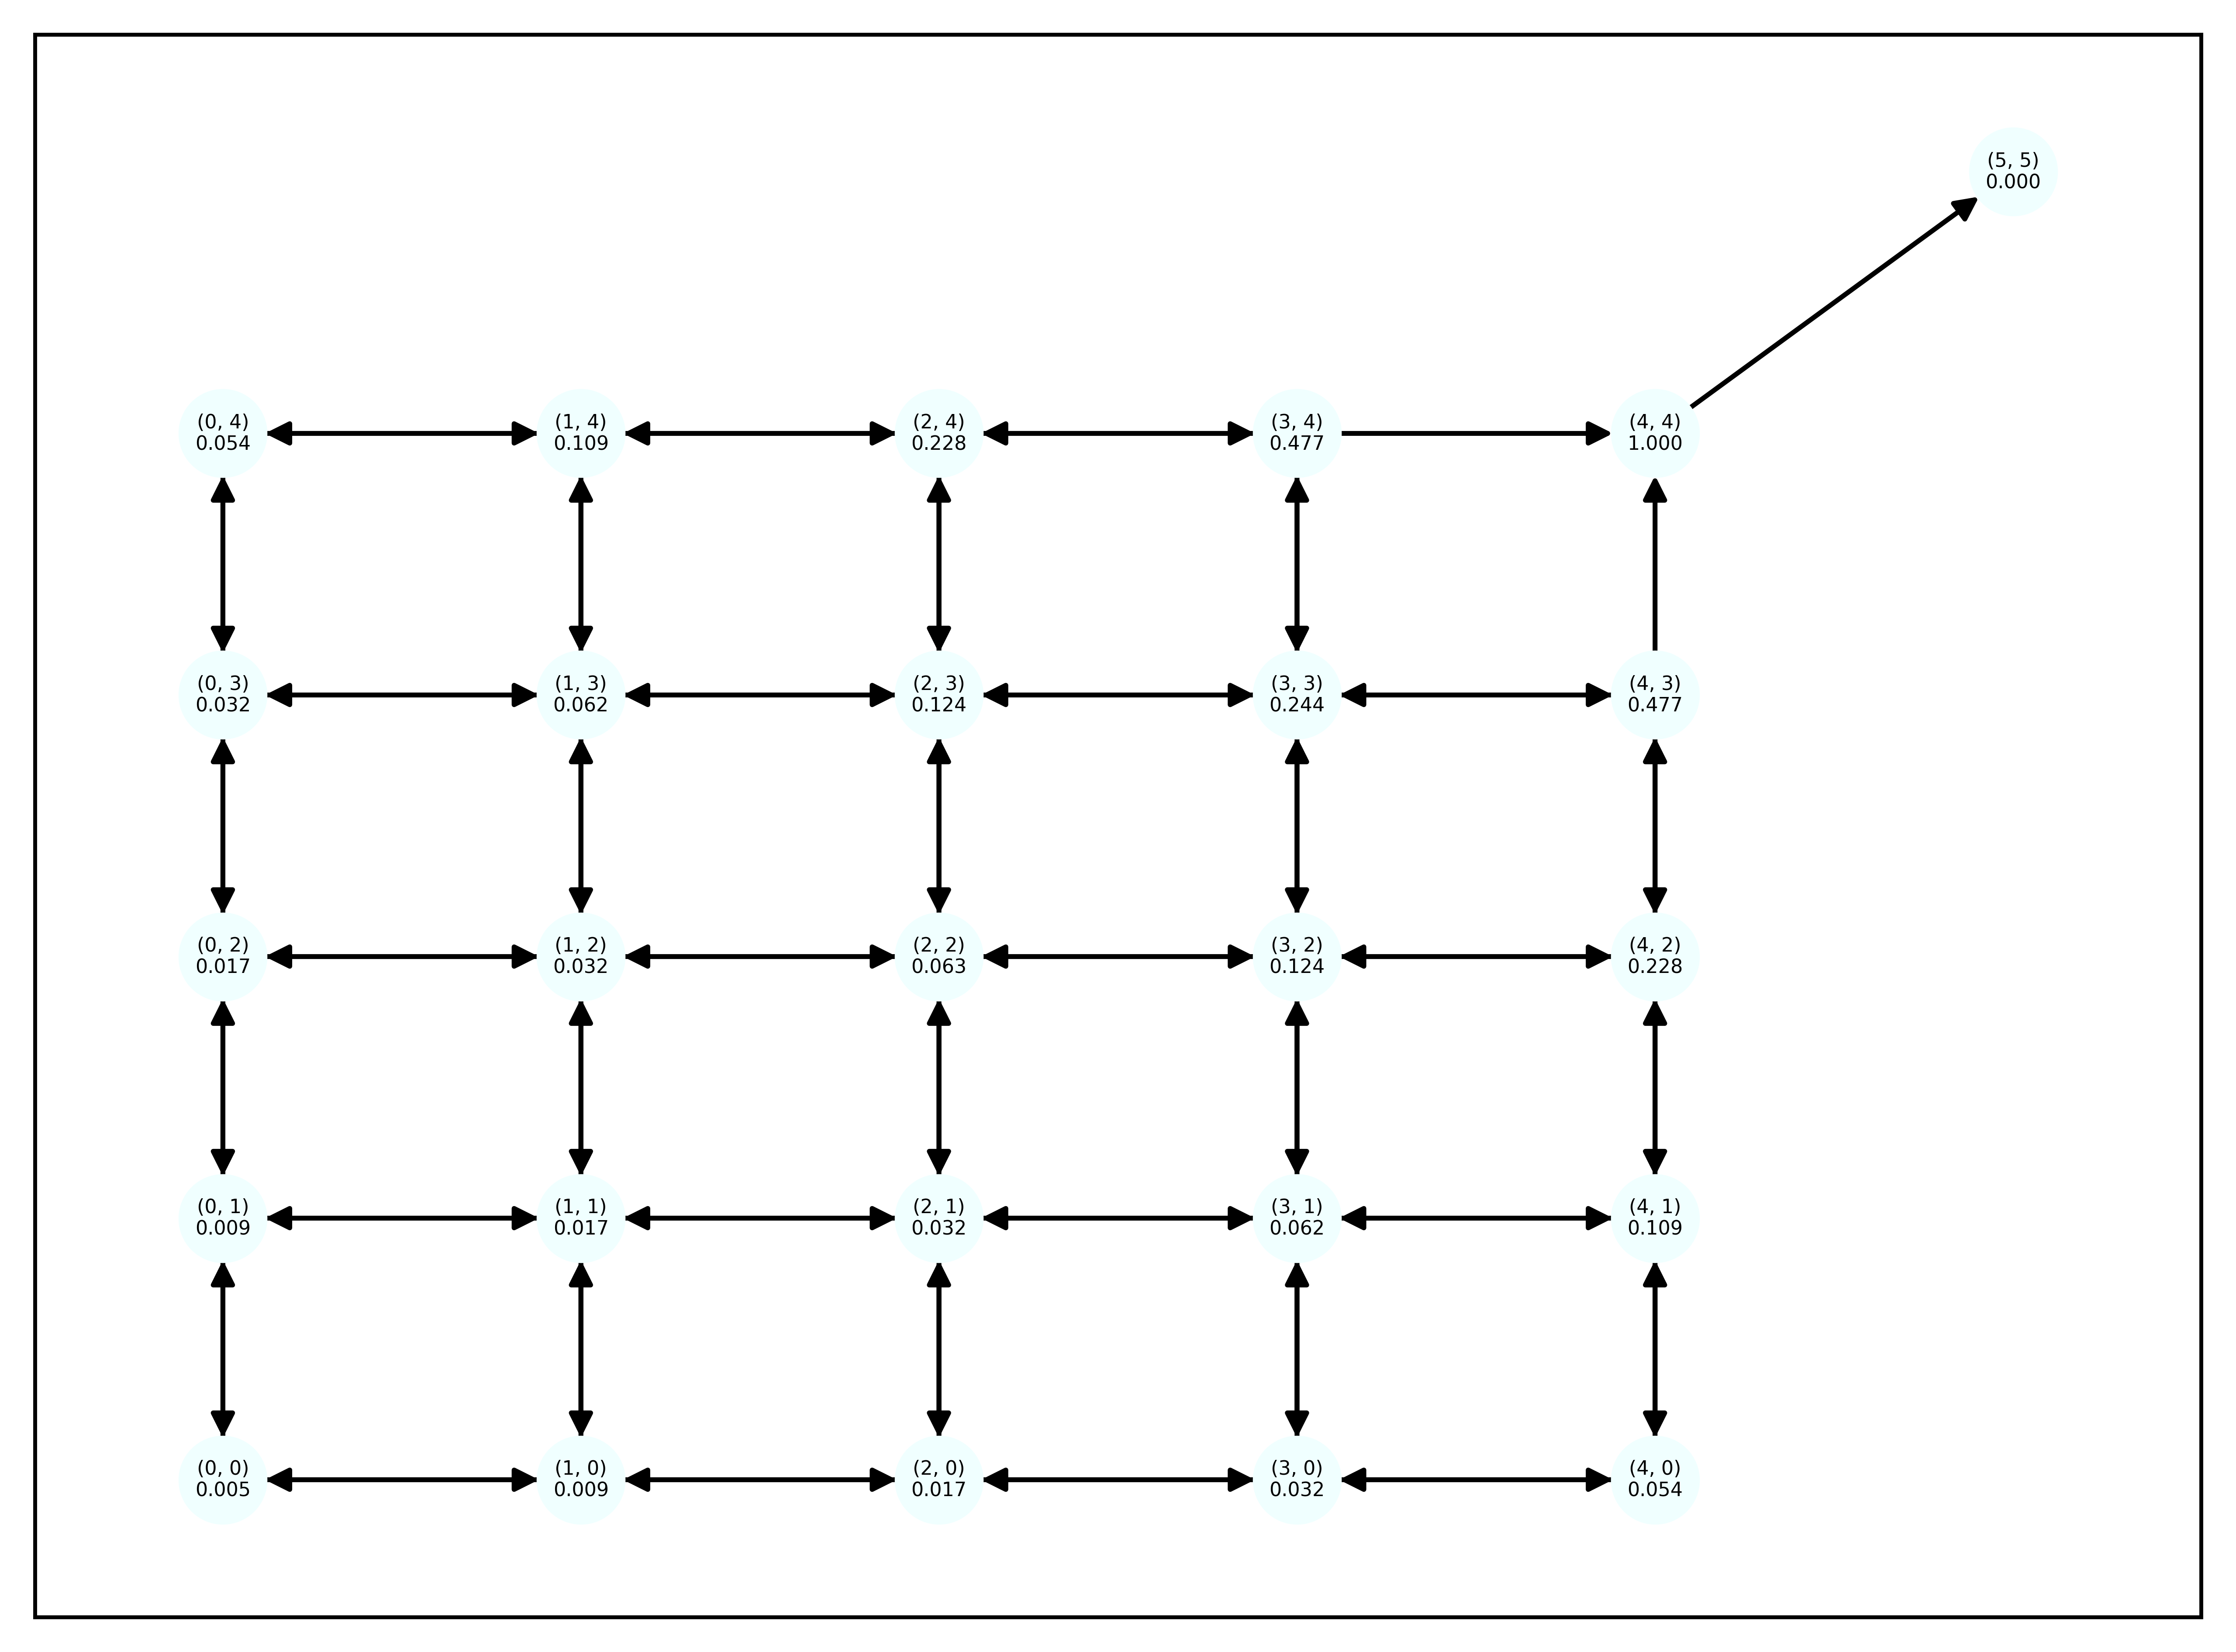

In [6]:
import networkx as nx

length = 10
colors = ['azure', 'lightsalmon', 'gold', 'palegreen', 'lemonchiffon', 'lavender']
dimensions = (length, length)
mdp = make_nd_grid_world(dimensions, stochasticity=0.3)
vi = ValueIteration(mdp)
vi.solve()
mdp_graph, labels = grid2graph(mdp)
parts = [0]*len(labels)
node_labels = { it[0]:str(it[1]) + '\n{:.3f}'.format(vi.values[it[1]]) for it in labels.items()}
draw_graph(mdp_graph, 'mdp', node_labels, parts, colors, label_dict = labels)

## Generate MDP and VI data

In [33]:
length = 8
colors = ['azure', 'lightsalmon', 'gold', 'palegreen', 'lemonchiffon', 'lavender']
dimensions = (length, length)

results_rank = []
for i in range(20):
    mdp = make_nd_grid_world(dimensions, stochasticity=0.2)
    vi = ValueIteration(mdp)
    vi.solve()
    sorted_values = sorted(vi.values.items(), key=lambda x: x[1])
    results_rank.append([i[0] for i in sorted_values])
#     results_rank.append([item[1] for item in vi.values.items()])

iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0
iter: 45 | counter: 0


## Validate

In [5]:
for i in range(len(results_rank)):
    for j in results_rank[i:]:
        if np.allclose(results_rank[i], j) == False:
            print(i, j)

## Dataset prepare
--------
**Input shape:** [Batchsize, num_nodes, node_feaatures]  
For node features, each node has five dimensional data  
**feature:** ndoe coordinate(node embedding in the future), initial value, requested node coordinate  
**label:** requested node value rank.   
The total output classes number is the number of total states

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import dgl
import time
import itertools
import numpy as np

from torch.utils.data import DataLoader, Dataset
from random import sample

Using backend: pytorch


In [6]:
def extract_reward(mdp:MDP, edges_list:list, i_act:int, node_embedding):
    rewards = []
    for edge in edges_list:
        # edge is in the form of (sp, s) because info is transmitted from edge src to dst
        state = tuple(node_embedding[edge[1]].tolist())
        next_state = tuple(node_embedding[edge[0]].tolist())
        action = mdp.actions[i_act]
        # TODO: reward should be s, a, sp as we assume s, a can transit to every other states
        transitions_sets = set(mdp.transition_function(state, action).keys())
        r = mdp.reward_function(state, action) if next_state in transitions_sets else 0
        rewards.append(r)
        
#     print(rewards)
    return rewards

def generate_dataset(mdp, values, action_dim, dataset_size=1, gamma=.7):
    original_values = sorted(values.items(), key=lambda x: x[1])
    values_rank = dict([(item[0], i) for i, item in enumerate(original_values)])
    graph_dataset = [] 
    labels = []
    # generate edges
    # including self edges cause there is prob that s,a transits to itself
    edges_list = [[i, j] for i in range(len(values)) for j in range(len(values))]
    edges = list(zip(*edges_list))
    # generate actions
    actions_col = [i for i in range(action_dim)]
    actions = np.zeros(shape=[len(actions_col), max(actions_col)+1])
    actions[np.arange(len(actions_col)), actions_col] = 1
    # generate rewards
    
    for i in range(dataset_size):
        g = dgl.DGLGraph()
        # add number of states nodes
        g.add_nodes(len(values))
        node_embedding = np.random.permutation(list(values.keys())).reshape(-1, 2)
        g.ndata['embedding'] = torch.Tensor(node_embedding)
        g.ndata['value'] = torch.rand(g.ndata['embedding'].shape[0]).view(-1, 1)
        requested_node = sample(node_embedding.tolist(), 1)
        g.ndata['requested_node'] = torch.Tensor(requested_node).view(1, -1).repeat(node_embedding.shape[0], 1)
        g.add_edges(*edges)
        for i_act in range(action_dim):
            g.edata['act'+str(i_act)] = torch.Tensor(actions[i_act]).view(1, -1).repeat(len(edges[0]), 1)
            reward_sa = extract_reward(mdp, edges_list, i_act, node_embedding)
            g.edata['r'+str(i_act)] = torch.zeros(len(reward_sa), node_embedding.shape[1] * 2 + 1)
            g.edata['r'+str(i_act)][:, -1] = torch.tensor(reward_sa)
        graph_dataset.append(g)
        labels.append(values_rank[tuple(requested_node[0])])
    
    gamma_vector = torch.ones(g.ndata['embedding'].shape[1]*2 + 1)
    gamma_vector[-1] = gamma
    
    return graph_dataset, labels, gamma_vector
    
# generate_dataset(6, vi.values)
    

In [7]:
class MDPGraphDataset(Dataset):
    """
    Dataset for MDP graphs
    Args:
        graphs_list: list of dgl graphs
        labels_list: list of graph labels(here is requested state value rank)
    """
    def __init__(self, graphs_list, labels_list):
        self.graphs = graphs_list
        self.labels_list = labels_list
        self.length = len(labels_list)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.graphs[idx], self.labels_list[idx]

In [11]:
graph_dataset, labels, gamma_vector = generate_dataset(mdp, vi.values, 4, dataset_size=1)

### Dataset Validation

In [238]:
graph_dataset[0].edata['r3'].shape

torch.Size([100, 5])

In [239]:
rlist = torch.where(graph_dataset[0].edata['r3'][:, -1].reshape(-1, ) == 1)[0].tolist()
print(type(rlist), rlist)
edges = torch.tensor(list(zip(*graph_dataset[0].find_edges(rlist)))).tolist()
print('positive reward edges u,v:\n', edges)


<class 'list'> [67]
positive reward edges u,v:
 [[6, 7]]


In [240]:
graph_dataset[0].ndata['embedding']

tensor([[0., 1.],
        [0., 0.],
        [1., 2.],
        [1., 1.],
        [2., 0.],
        [1., 0.],
        [3., 3.],
        [2., 2.],
        [0., 2.],
        [2., 1.]])

In [14]:
labels

[4]

In [221]:
gamma_vector

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.7000])

In [20]:
original_values = sorted(vi.values.items(), key=lambda x: x[1])
values_rank = dict([(item[0], i) for i, item in enumerate(original_values)])
values_rank

{(3, 3): 0,
 (0, 0): 1,
 (1, 0): 2,
 (0, 1): 3,
 (2, 0): 4,
 (0, 2): 5,
 (1, 1): 6,
 (2, 1): 7,
 (1, 2): 8,
 (2, 2): 9}

### Graph Validation

In [113]:
import dgl
import torch

G = dgl.DGLGraph()
G.add_nodes(4)
G.add_edge(0,1)
G.edges[G.edge_id(0,1)].data['test'] = torch.ones(1)*3
G.edges[G.edge_id(0,1)].data['test2'] = torch.ones(1,2)*2

G.add_edge(1,2)
G.add_edge(1,2)
# G.edge_id(0, 1, return_array=True)
G.add_edge(0,1)
G.add_edge(1,2)
G.edges[2].data['test'] = torch.ones(1)*2

def test_func(edges):
    new_dict = {'test3':torch.ones(3)} 
    new_dict.update(edges.data)
    print(*new_dict.items())
#     return {'sum': edges.data}

# G.apply_edges(test_func)
# G.edata.pop('test')
# G.edata
# G.edge_id(0, 1, return_array=True)
# G.edata

G.add_edges([1,2],[2,3])
# G.all_edges(form='all')
edges_list = list(zip(*G.all_edges('uv')))
for edge in edges_list:
    print(edge)

(tensor(0), tensor(1))
(tensor(1), tensor(2))
(tensor(1), tensor(2))
(tensor(0), tensor(1))
(tensor(1), tensor(2))
(tensor(1), tensor(2))
(tensor(2), tensor(3))


## Deep Value Iteration Layer and Model

### VI Layer

In [8]:
class VILayer(nn.Module):
    def __init__(self, state_embed_dim, mid_dim, gamma_vec = None, action_dim = 4):
        super(VILayer, self).__init__()
        self.state_embed_dim = state_embed_dim
        self.mid_dim = mid_dim
        # only multiply the value dimension of state embedding
        if torch.is_tensor(gamma_vec):
            self.register_buffer('gamma_vec', gamma_vec)
        else:
            self.register_buffer('gamma_vec', torch.tensor(gamma_vec))
        # only add rewards on the value dimension of state embedding
        self.action_dim = action_dim
        
        self.fc = nn.Linear(state_embed_dim, mid_dim, bias=False)
        self.reward_fc = nn.Linear(state_embed_dim, mid_dim, bias=False)
        self.gamma_fc = nn.Linear(state_embed_dim, mid_dim, bias=False)
        self.atten = nn.Linear(mid_dim*2 + action_dim, 1, bias=False)
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)
        self.max_mlp = nn.Sequential(
            nn.Linear(mid_dim * self.action_dim, mid_dim),
            nn.LeakyReLU(),
            nn.Linear(mid_dim, state_embed_dim),
            nn.LeakyReLU()
        )
        
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn.weight, gain=gain)
        for layer in self.max_mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight, gain=gain)
    
    def edge_attention(self, edges):
        # estimate transition prob(info_dst, a, info_src)
        # equation 2
        edge_features = {}
        for i in range(self.action_dim):
            concat_features = torch.cat([edges.dst['z'], edges.data['act'+str(i)], edges.src['z']], dim=1)
            concat_features = self.atten(concat_features)
            edge_features['e'+str(i)] = self.leaky_relu(concat_features)
        
        return edge_features

    def message_func(self, edges):
        message_dict = {'z': edges.src['z']}
        message_dict.update(edges.data) 
        return message_dict
    
    def reduce_func(self, nodes):
        # collect messages in mailbox and reduce infomation for dst node
        q_values = []
        for i in range(self.action_dim):
            # Fix s,a and take average over all s'
            # equation 3
            alpha = self.softmax(nodes.mailbox['e'+str(i)])
            # equation 4
            reward_embed = F.leaky_relu(self.reward_fc(nodes.mailbox['r'+str(i)]))
            gamma_embed = F.relu(self.gamma_fc(self.gamma_vec))
            weighted_value = alpha * (gamma_embed * nodes.mailbox['z'] + reward_embed)
            q_value = torch.sum(weighted_value, dim=1)
            q_values.append(q_value)
        h = self.max_mlp(torch.cat(q_values, dim=1))
        return {'h': h}
    
    def forward(self, graph, node_features):
        # equation 1
        z = self.fc(node_features)
        graph.ndata['z'] = z
        # equation 2
        graph.apply_edges(self.edge_attention)
        # equation 3/4
        graph.update_all(self.message_func, self.reduce_func)
        
        return graph.ndata.pop('h')
    

### Full Model Definition

In [9]:
class DeepVI(nn.Module):
    def __init__(self, in_dim, mid_dim, out_classes, gamma_vec, action_dim=4):
        super(DeepVI, self).__init__()
        self.in_dim = in_dim
        self.mid_dim = mid_dim
        self.out_classes = out_classes
        self.action_dim = action_dim
        if torch.is_tensor(gamma_vec):
            self.register_buffer('gamma_vec', gamma_vec)
        else:
            self.register_buffer('gamma_vec', torch.tensor(gamma_vec))
        
        self.vconv = VILayer(in_dim, mid_dim, self.gamma_vec, action_dim)
        self.vconv2 = VILayer(in_dim, mid_dim, self.gamma_vec, action_dim)
        self.vconv3 = VILayer(in_dim, mid_dim, self.gamma_vec, action_dim)
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, in_dim * 10),
            nn.LeakyReLU(),
            nn.Linear(in_dim * 10, out_classes),
        )
        
    def forward(self, batch_g):
        h = torch.cat([batch_g.ndata['embedding'], batch_g.ndata['requested_node'], batch_g.ndata['value']], dim=1)
        # Value Iteration 
        h = F.leaky_relu(self.vconv(batch_g, h))
        h = F.leaky_relu(self.vconv2(batch_g, h))
        h = F.leaky_relu(self.vconv3(batch_g, h))
        
        batch_g.ndata['h'] = h
        # Calculate graph representation by concating all the node representations
        # mean or concat??
        mean_h = dgl.mean_nodes(batch_g, 'h')
        return self.classifier(mean_h)

## Train Utils

In [10]:
def collate(samples):
    # The input samples is a list of pairs
    # (graph, label)
    graphs, labels = list(zip(*samples))
    batch_graph = dgl.batch(graphs)
    return batch_graph, torch.tensor(labels)

def train_model(model, device, dataloaders, criterion, optimizer, scheduler, writer=None,
                num_epoches=1, saved_name='', best_acc=0.0, save_path='.'):
    since = time.time()
    if saved_name == '':
        print('Please provide a path for saving pth file. eg. save_name = your_model.pth')
        return

    best_acc = best_acc
    best_loss = np.inf
    dataset_sizes = {'train': len(dataloaders['train'].dataset),
                     'test': len(dataloaders['test'].dataset)}
    step = 0
    for epoch in range(num_epoches):
        print('Epoch {}/{}'.format(epoch+1, num_epoches))
        print('-' * 10)

        # Each epoch has a training and validation/test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    try:
                        outputs = model(inputs)
                    except RuntimeError as e:
                        if 'out of memory' in str(e):
                            del inputs
                            del labels
                            print('Out of CUDA memory')
                            return model
                        else:
                            raise e
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        step += 1

                # statistics
                running_loss += loss.item() * labels.shape[0]
                running_corrects += torch.sum(preds == labels.data)
                if writer is not None:
                    writer.add_scalar(saved_name+' batch loss', loss.item(), step)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if writer is not None:            
                writer.add_scalar(saved_name+' epoch acc', epoch_acc, epoch)


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                torch.save(model.state_dict(), os.path.join(save_path, saved_name + '.pth'))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f} | val loss: {:4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(torch.load(os.path.join(save_path, saved_name + '.pth')))
    return model

## Train and Test

In [11]:
from tqdm import tqdm_notebook as tqdm

In [12]:
graphs, labels, gamma_vector = generate_dataset(mdp, vi.values, 4, dataset_size=15000)

In [13]:
trainset = MDPGraphDataset(graphs[:13000], labels[:13000])
testset = MDPGraphDataset(graphs[13000:], labels[13000:])
train_loader = DataLoader(trainset, batch_size=80, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=64, shuffle=True, collate_fn=collate)
dataloaders = {'train': train_loader, 'test': test_loader}

In [20]:
device = torch.device('cuda:0')
model = DeepVI(5, 50, len(mdp.states), gamma_vector).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# optimizer = optim.Adam(optimized_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [15]:
next(iter(trainset))

(DGLGraph(num_nodes=65, num_edges=4225,
          ndata_schemes={'embedding': Scheme(shape=(2,), dtype=torch.float32), 'value': Scheme(shape=(1,), dtype=torch.float32), 'requested_node': Scheme(shape=(2,), dtype=torch.float32)}
          edata_schemes={'act0': Scheme(shape=(4,), dtype=torch.float32), 'r0': Scheme(shape=(5,), dtype=torch.float32), 'act1': Scheme(shape=(4,), dtype=torch.float32), 'r1': Scheme(shape=(5,), dtype=torch.float32), 'act2': Scheme(shape=(4,), dtype=torch.float32), 'r2': Scheme(shape=(5,), dtype=torch.float32), 'act3': Scheme(shape=(4,), dtype=torch.float32), 'r3': Scheme(shape=(5,), dtype=torch.float32)}),
 62)

In [22]:
optimized_model = train_model(model, 
                              device, 
                              dataloaders, 
                              loss_func, 
                              optimizer, 
                              scheduler, 
                              num_epoches=50,
                              saved_name='gnnvi_w'+str(length)+'_best')

Epoch 1/50
----------



train Loss: 2.3019 Acc: 0.2143



test Loss: 1.8537 Acc: 0.3210

Epoch 2/50
----------



train Loss: 1.7340 Acc: 0.3450



test Loss: 1.7989 Acc: 0.3315

Epoch 3/50
----------



train Loss: 1.4734 Acc: 0.4100



test Loss: 1.4439 Acc: 0.3700

Epoch 4/50
----------



train Loss: 1.2998 Acc: 0.4764



test Loss: 1.1641 Acc: 0.5515

Epoch 5/50
----------



train Loss: 1.2382 Acc: 0.5002



test Loss: 1.1019 Acc: 0.5945

Epoch 6/50
----------



train Loss: 1.0262 Acc: 0.5863



test Loss: 0.9141 Acc: 0.6535

Epoch 7/50
----------



train Loss: 0.7343 Acc: 0.8563



test Loss: 0.6954 Acc: 0.8920

Epoch 8/50
----------



train Loss: 0.6598 Acc: 0.8913



test Loss: 0.6413 Acc: 0.8975

Epoch 9/50
----------



train Loss: 0.6079 Acc: 0.9062



test Loss: 0.6101 Acc: 0.8585

Epoch 10/50
----------



train Loss: 0.5746 Acc: 0.9059



test Loss: 0.5612 Acc: 0.8775

Epoch 11/50
----------



train Loss: 0.5340 Acc: 0.9078



test Loss: 0.5874 Acc: 0.8965

Epoch 12/50
----------



train Loss: 0.5600 Acc: 0.8927



test Loss: 0.5093 Acc: 0.9025

Epoch 13/50
----------



train Loss: 0.4743 Acc: 0.9385



test Loss: 0.4796 Acc: 0.9390

Epoch 14/50
----------



train Loss: 0.4661 Acc: 0.9502



test Loss: 0.4724 Acc: 0.9540

Epoch 15/50
----------



train Loss: 0.4618 Acc: 0.9522



test Loss: 0.4688 Acc: 0.9385

Epoch 16/50
----------



train Loss: 0.4565 Acc: 0.9465



test Loss: 0.4609 Acc: 0.9545

Epoch 17/50
----------



train Loss: 0.4505 Acc: 0.9511



test Loss: 0.4566 Acc: 0.9540

Epoch 18/50
----------



train Loss: 0.4454 Acc: 0.9539



test Loss: 0.4497 Acc: 0.9715

Epoch 19/50
----------



train Loss: 0.4408 Acc: 0.9697



test Loss: 0.4484 Acc: 0.9715

Epoch 20/50
----------



train Loss: 0.4399 Acc: 0.9697



test Loss: 0.4481 Acc: 0.9715

Epoch 21/50
----------



train Loss: 0.4393 Acc: 0.9697



test Loss: 0.4471 Acc: 0.9715

Epoch 22/50
----------



train Loss: 0.4387 Acc: 0.9614



test Loss: 0.4464 Acc: 0.9715

Epoch 23/50
----------



train Loss: 0.4381 Acc: 0.9697



test Loss: 0.4461 Acc: 0.9715

Epoch 24/50
----------



train Loss: 0.4374 Acc: 0.9695



test Loss: 0.4452 Acc: 0.9715

Epoch 25/50
----------



train Loss: 0.4368 Acc: 0.9697



test Loss: 0.4450 Acc: 0.9715

Epoch 26/50
----------



train Loss: 0.4367 Acc: 0.9697



test Loss: 0.4450 Acc: 0.9715

Epoch 27/50
----------


KeyboardInterrupt: 